In [101]:
import tensorflow as tf
import numpy as np
import epsilon_rho
import metrics
import re


# Function to read and parse the tensor data from a text file
def parse_tensor_from_file(file_path, shape):
    with open(file_path, 'r') as file:
        # Read the content of the file
        tensor_str = file.read()
    # Split the cleaned string into components
    print(tensor_str)
    components = re.findall(r"([+-]?\d+\.?\d*[eE]?[+-]?\d*(?:\s*[+-]?\d*\.?\d*[eE]?[+-]?\d*j)?)", tensor_str)
    print(components)
    # Convert the components into a numpy array of complex numbers
    complex_numbers = [complex(c.replace(' ','')) for c in components]

    # Convert the list to a NumPy array and reshape it
    numpy_tensor = np.array(complex_numbers, dtype=np.complex128)

    if (shape == 3):
        numpy_tensor = numpy_tensor.reshape(round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)))
    if (shape == 2):
        size = numpy_tensor.size
        new_shape = (round(size ** (1/shape)), round(size ** (1/shape))) if shape == 2 else (size,)
        numpy_tensor = numpy_tensor.reshape(new_shape)
    # Convert NumPy array to TensorFlow tensor
    tf_tensor = tf.convert_to_tensor(numpy_tensor)

    return tf_tensor

def normalize_density_matrix(rho):
    # Calculate the trace of the density matrix
    trace = np.trace(rho)
    
    # Normalize the density matrix
    if trace != 0:
        normalized_rho = rho / trace
    else:
        raise ValueError("The density matrix has a trace of zero and cannot be normalized.")
    
    return normalized_rho

In [8]:
import os

def retrieve_dict(base_dir, filename):
    # Dictionary to hold costs organized by prefix (i)
    fidelity_dict = {}
    
    # Iterate through each subfolder in the base directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            # Extract the prefix for identifying the 'i' value
            prefix = folder_name.split('_')[0]
            # Path to the cost.txt file
            cost_file_path = os.path.join(folder_path, filename)
            
            # Read the cost value from the cost.txt file
            if os.path.exists(cost_file_path):
                    # Extract the complex number part using regular expression
                    tensor = parse_tensor_from_file(cost_file_path, 1)
                    # Convert the extracted string to a complex number
                    for t in tensor.numpy():
                         # Get the real part and convert to float
                         float_value = t.real
                         # if (float_value < 10e-4): continue
                         if prefix not in fidelity_dict:
                              fidelity_dict[prefix] = []
                         fidelity_dict[prefix].append(abs(float_value))
    
    return fidelity_dict

def retrieve_Z_dict(base_dir):
     # Iterate through each subfolder in the base directory
     Z_dict = {}

     for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
          # Path to the cost.txt file
          parts = folder_path.split('_')  # Split by underscore
          postfix = parts[-1]  # Get the last part
          
          rho2_file_path = os.path.join(folder_path, 'tr_rho2.txt')
          out_rho2_file_path = os.path.join(folder_path, 'tr_out_rho2.txt')
          if not os.path.exists(rho2_file_path):
              return Z_dict
          #print(rho2_file_path, out_rho2_file_path)
          with open(rho2_file_path, 'r') as file:
               # Extract the complex number part using regular expression
               str_rho2 = file.read().strip()
               # Convert the extracted string to a complex number
               num_rho2 = abs(float(str_rho2))

          with open(out_rho2_file_path, 'r') as file:
               # Extract the complex number part using regular expression
               str_out_rho2 = file.read().strip()
               # Convert the extracted string to a complex number
               num_out_rho2 = abs(float(str_out_rho2))

          if "$\\rho'$"+" ("+postfix+")" not in Z_dict:
               Z_dict["$\\rho'$"+" ("+postfix+")"] = []
          if "$\\overline{\\rho'}$"+" ("+postfix+")" not in Z_dict:
               Z_dict["$\\overline{\\rho'}$"+" ("+postfix+")"] = []     
          Z_dict["$\\rho'$"+" ("+postfix+")"].append((num_rho2))
          Z_dict["$\\overline{\\rho'}$"+" ("+postfix+")"].append((num_out_rho2))
     return Z_dict


In [95]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fidelity(fidelity_dict1, fidelity_dict2, ylabel1, ylabel2, xlabel, file_name):
    # Set font family to serif
    plt.rc('font', family='serif')
    # Create a figure with two subplots stacked vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.5, 6.5), sharex=True)
    colorList = ['r', 'g', 'b', 'magenta', 'orange']
    
    # Plot for the first fidelity dict on the first subplot (top plot)
    for i, (key, values) in enumerate(fidelity_dict1.items()):
        ax1.plot(values[1:], label="N = " + key, color=colorList[i % len(colorList)])  # Use color cycling for variety

    # Adding labels and title to the first plot
    ax1.set_ylabel(ylabel1, fontsize=16)
    ax1.set_title(ylabel1 + ' on ' + xlabel + ' change', fontsize=16)  # Optional: title for the first plot
    ax1.set_yscale('log')  # Set y-axis to logarithmic scale
    ax1.grid(True)
    ax1.legend(fontsize=13, ncol=2)
    
    # Plot for the second fidelity dict on the second subplot (bottom plot)
    for i, (key, values) in enumerate(fidelity_dict2.items()):
        ax2.plot(values[1:], label="N = " + key, color=colorList[i % len(colorList)])

    # Adding labels and title to the second plot
    ax2.set_xlabel(xlabel, fontsize=16)  # Shared x-axis label at the bottom
    ax2.set_ylabel(ylabel2, fontsize=16)
    ax2.set_title(ylabel2 + ' on ' + xlabel + ' change', fontsize=16)  # Optional: title for the second plot
    ax2.set_yscale('log')  # Set y-axis to logarithmic scale
    ax2.grid(True)
    ax2.legend(fontsize=13, ncol=2)

    # Customizing x-axis ticks (you can adjust this based on your data)
    x_ticks = np.arange(0, 20, step=2)  # Adjust step size based on your data
    x_tick_labels = [f'{(tick/20 + 0.05):.2f}' for tick in x_ticks]  # Convert to float and format
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_tick_labels)
    ax1.tick_params(axis='y', labelsize=13) 
    ax2.tick_params(axis='y', labelsize=13)
    
    ax1.tick_params(axis='x', labelsize=13)
    ax2.tick_params(axis='x', labelsize=13)
    # Save the figure
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f'docs/{file_name}.png', format='png')
    plt.savefig(f'docs/{file_name}.eps', format='eps')

    # Display the plot
    plt.show()

fidelity_dict_rho_rho3 = retrieve_dict('experiment_result_dephasing_2', 'fidelity_rho_rho3.txt')
print(fidelity_dict_rho_rho3)
fidelity_dict_rho2_rho2 = retrieve_dict('experiment_result_dephasing_2', 'fidelity_rho2_rho2.txt')
plot_fidelity(fidelity_dict_rho_rho3, fidelity_dict_rho2_rho2, "Infidelity($\\rho$, $\\rho''$)", "Infidelity($\\rho'$, $\\rho'_{Unitary}$)", '$\\gamma$', 'fidelity_rho-rho3_rho-rho2_2')

(-2.220446049250313e-16+0j)
['-2.220446049250313e-16+0j']
(0.005148491868056548+0j)
['0.005148491868056548+0j']
(0.010351115388876564+0j)
['0.010351115388876564+0j']
(0.015609614771952995+0j)
['0.015609614771952995+0j']
(0.020925829957578745+0j)
['0.020925829957578745+0j']
(0.0263017041382847+0j)
['0.0263017041382847+0j']
(0.03173929205756343+0j)
['0.03173929205756343+0j']
(0.03724076918638275+0j)
['0.03724076918638275+0j']
(0.042808441893696814+0j)
['0.042808441893696814+0j']
(0.048444758745811556+0j)
['0.048444758745811556+0j']
(0.054152323091633314+0j)
['0.054152323091633314+0j']
(0.05993390711730007+0j)
['0.05993390711730007+0j']
(0.0657924675854833+0j)
['0.0657924675854833+0j']
(0.07173116351296094+0j)
['0.07173116351296094+0j']
(0.07775337608641486+0j)
['0.07775337608641486+0j']
(0.08386273117289833+0j)
['0.08386273117289833+0j']
(0.09006312485049839+0j)
['0.09006312485049839+0j']
(0.09635875018193796+0j)
['0.09635875018193796+0j']
(0.10274988102038918+0j)
['0.10274988102038918+0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [96]:
import matplotlib.pyplot as plt

def plot_dict (fidelity_dict, xlabel, ylabel, file_name, max, step, maxNum):
    # Plotting
    plt.rc('font', family='serif')
    plt.figure(figsize=(7.5, 5))

    # Plot each category
    i = 0
    for key, values in fidelity_dict.items():
        x = np.arange(len(values))  # Generate x-values
        if "overline" in key.lower():
            # Plot as lines for other keys
            plt.plot(
                x, values, label=key, linestyle=':', alpha=1, linewidth=4
            )
        else:
            # Plot as dots for keys containing 'unitary'
            plt.plot(
                x, values, label=key, linestyle='-', alpha=1, linewidth=2
            )
            

    # Adding title and labels
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

    #plt.yscale('log')  # Set y-axis to logarithmic scale
    # Customizing x-axis ticks
    x_ticks = np.arange(0, max, step=step)  # Adjust step size based on your data
    if max-1 not in x_ticks:
        x_ticks = np.append(x_ticks, max-1)
    x_tick_labels = [f'{tick/(max-1)*maxNum:.0f}' for tick in x_ticks]  # Convert to float and format
    
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14) 
    plt.grid(True)
    plt.legend(fontsize=14)
    
    plt.savefig('docs/'+file_name+'.png', format='png',  bbox_inches='tight')
    plt.savefig('docs/'+file_name+'.eps', format='eps',  bbox_inches='tight')
    

    # Display the plot
    plt.show()


trace_dict = retrieve_Z_dict('experiment_result_X')
plot_dict(fidelity_dict=trace_dict, xlabel='t', ylabel="$\\langle X_1(t)\\rangle$ and $\\langle \\overline{X_1}(t)\\rangle$", file_name="trace_X", max=201, step=30, maxNum=100)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(8.557519137752934e-10+0j)
['8.557519137752934e-10+0j']
(1.430973117777512e-09+5.0152544927248656e-21j)
['1.430973117777512e-09+5.0152544927248656e-21j']
(3.94804744452415e-09+4.604580163452847e-21j)
['3.94804744452415e-09+4.604580163452847e-21j']
(6.041062539097197e-09+2.09697134488116e-21j)
['6.041062539097197e-09+2.09697134488116e-21j']
(-7.263438517313148e-09+1.7528784032445073e-21j)
['-7.263438517313148e-09+1.7528784032445073e-21j']
(8.490161906848925e-10+0j)
['8.490161906848925e-10+0j']
(-1.949062466977125e-09+1.336397853000657e-21j)
['-1.949062466977125e-09+1.336397853000657e-21j']
(5.631767940883492e-09+3.7869027122976295e-21j)
['5.631767940883492e-09+3.7869027122976295e-21j']
(1.0416530304979688e-08+8.8259644291855e-22j)
['1.0416530304979688e-08+8.8259644291855e-22j']
(-2.2638882768433177e-08+9.481400462787077e-22j)
['-2.2638882768433177e-08+9.481400462787077e-22j']
{"infidelity($\\rho$, $\\rho''$)": [8.557519137752934e-10, 1.430973117777512e-09, 3.94804744452415e-09, 6.041062

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


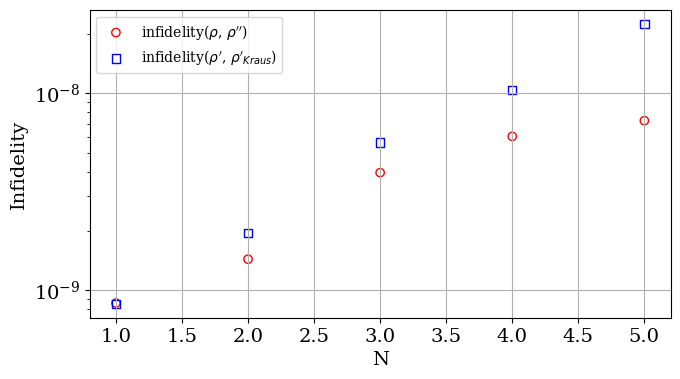

In [97]:

def retrieve_dict(base_dir, filename):
    # Dictionary to hold costs organized by prefix (i)
    fidelity_dict = {}
    
    # Iterate through each subfolder in the base directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            # Extract the prefix for identifying the 'i' value
            prefix = folder_name.split('_')[0]
            # Path to the cost.txt file
            cost_file_path = os.path.join(folder_path, filename)
            
            # Read the cost value from the cost.txt file
            if os.path.exists(cost_file_path):
                    # Extract the complex number part using regular expression
                    tensor = parse_tensor_from_file(cost_file_path, 1)
                    # Convert the extracted string to a complex number
                    for t in tensor.numpy():
                         # Get the real part and convert to float
                         float_value = t.real
                         if prefix not in fidelity_dict:
                              fidelity_dict[prefix] = []
                         fidelity_dict[prefix].append(abs(float_value))
    
    return fidelity_dict
def merge_dicts(dict_list, labels):
    """
    Merges multiple dictionaries into one, with new keys labeled by the given labels.

    Parameters:
        dict_list (list of dict): List of dictionaries to merge.
        labels (list of str): Labels for each dictionary.

    Returns:
        dict: Merged dictionary with new keys.
    """
    merged_dict = {}
    for i, (d, label) in enumerate(zip(dict_list, labels)):
        for key, values in d.items():
            new_key = f"{label}"
            if new_key not in merged_dict:
               merged_dict[new_key] = []
            for v in values:
                merged_dict[new_key].append(v)
    return merged_dict

import matplotlib.pyplot as plt

def plot_fidelity(qubits, data, xlabel, ylabel, file_name):
    """
    Plots a scatter plot for 1 - Fidelity vs. Number of Qubits.

    Parameters:
    qubits (list): List of the number of qubits.
    data_rho_rho3 (list): Fidelity values for '1 - f(rho, rho3)'.
    data_rho2_kraus (list): Fidelity values for '1 - f(rho2, rho2_kraus)'.
    """
    # Scatter Plot
    plt.figure(figsize=(7.5, 4))
    for label, values in data.items():
        marker = 's' if 'Kraus' in label else 'o'
        color = 'blue' if 'Kraus' in label else 'red'
        print(data)
        plt.scatter(qubits, values, marker=marker, color=color, label=label, facecolors='none')

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14) 
    plt.grid(True)
    plt.legend()
    plt.savefig('docs/'+file_name+'.png', format='png',  bbox_inches='tight')
    plt.savefig('docs/'+file_name+'.eps', format='eps',  bbox_inches='tight')
    

    # Display the plot
    plt.show()
    
folder_path = 'experiment_result_kraus_2'
dict = retrieve_dict(folder_path, 'fidelity_rho_rho3.txt')
dict2 = retrieve_dict(folder_path, 'fidelity_rho2_rho2.txt')
qubits = [1, 2, 3, 4, 5]
merged = merge_dicts([dict, dict2], ["infidelity($\\rho$, $\\rho''$)", "infidelity($\\rho'$, $\\rho'_{Kraus}$)"])

plot_fidelity(qubits, merged, "N", "Infidelity", "fidelity_rho03_rho22_2")



In [98]:
def retrieve_dict(base_dir, filename):
    # Dictionary to hold costs organized by prefix (i)
    fidelity_dict = {}
    
    # Iterate through each subfolder in the base directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            # Extract the prefix for identifying the 'i' value
            prefix = folder_name.split('_')[0]
            # Path to the cost.txt file
            cost_file_path = os.path.join(folder_path, filename)
            
            # Read the cost value from the cost.txt file
            if os.path.exists(cost_file_path):
                    # Extract the complex number part using regular expression
                    tensor = parse_tensor_from_file(cost_file_path, 1)
                    # Convert the extracted string to a complex number
                    for t in tensor.numpy():
                         # Get the real part and convert to float
                         float_value = t.real
                         if prefix not in fidelity_dict:
                              fidelity_dict[prefix] = []
                         fidelity_dict[prefix].append(abs(float_value))
    
    return fidelity_dict
def plot_dict (fidelity_dict, xlabel, ylabel, file_name, max, step):
    # Plotting
    plt.figure(figsize=(7.5, 4))

    # Plot each category
    i = 0
    for key, values in fidelity_dict.items():
        plt.plot(values, label="N="+key)
    
    # Adding title and labels
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    plt.yscale('log')  # Set y-axis to logarithmic scale
    # Customizing x-axis ticks
    x_ticks = np.arange(0, max, step=step)  # Adjust step size based on your data
    #x_tick_labels = [f'{tick/max:.2f}' for tick in x_ticks]  # Convert to float and format
    plt.xticks(ticks=x_ticks, fontsize=14)
    plt.yticks(fontsize=14) 
    plt.grid(True)
    plt.legend()
    plt.savefig('docs/'+file_name+'.png', format='png',  bbox_inches='tight')
    plt.savefig('docs/'+file_name+'.eps', format='eps',  bbox_inches='tight')
    

    # Display the plot
    plt.show()

folder_path = 'experiment_result_kraus_2'
dict = retrieve_dict(folder_path, 'costdict.txt')
plot_dict(dict, "Iteration", "C(K)", "cost_iterations_2", 1050, 100)


[0.27709088066591825, 0.20156208140527965, 0.12122399222390878, 0.04228340953648757, -0.022485934133067653, -0.06646190236532035, -0.09180798816786773, -0.10077891063035493, -0.09527509881758145, -0.07796821377716778, -0.052534664773260964, -0.023257018743745528, 0.005591985800830979, 0.030426068938627204, 0.04886771296824266, 0.059856827643335, 0.06338576780095329, 0.060139694179196734, 0.05123554190120272, 0.038084086328690536, 0.022322232679995557, 0.005752437952427081, -0.009763598888317349, -0.02248670013752907, -0.03104190202128687, -0.03464818794265745, -0.03324239416664865, -0.027448385511404272, -0.018417724188956708, -0.007608190529812209, 0.003442096710973619, 0.01331258993823603, 0.02085503718771098, 0.025297528378791845, 0.026296123973106322, 0.023938682058188387, 0.018709276856171297, 0.011419996042140612, 0.0031119448803250682, -0.005074923692395927, -0.012057330365848662, -0.016969439762732685, -0.019295297978030312, -0.01893867604812227, -0.016212165708188175, -0.01175

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


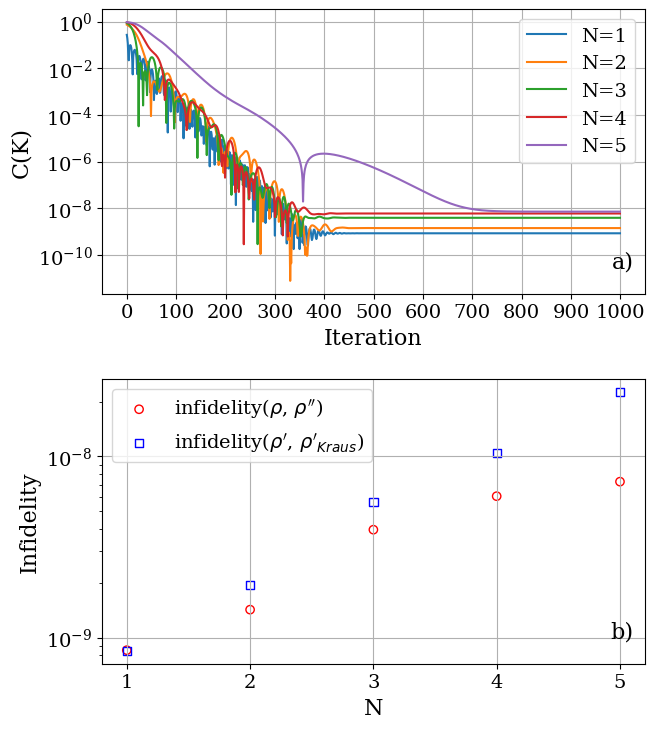

In [99]:
def plot_dict(fidelity_dict, xlabel, ylabel, file_name, max_val, step):
    # Plotting
    for i, (key, values) in enumerate(fidelity_dict.items()):
        plt.plot(values, label=f"N={key}")
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    x_ticks = np.arange(0, max_val, step=step)
    plt.xticks(ticks=x_ticks, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=14)

def plot_fidelity(qubits, data, xlabel, ylabel, file_name):
    # Scatter Plot
    for label, values in data.items():
        marker = 's' if 'Kraus' in label else 'o'
        color = 'blue' if 'Kraus' in label else 'red'
        plt.scatter(qubits, values, marker=marker, color=color, label=label, facecolors='none')
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    x_ticks = np.arange(qubits[0], qubits[-1]+1, step=1)
    plt.xticks(ticks=x_ticks, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=14)
def combined_plot(fidelity_dict, qubits, fidelity_data, xlabel_a, ylabel_a, xlabel_b, ylabel_b, file_name, max_val, step):
    # Create the figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(7, 8.5))  # Adjust the size of the figure

    # Plot for the first subplot (a)
    plt.sca(axs[0])  # Select the first subplot
    plot_dict(fidelity_dict, xlabel_a, ylabel_a, file_name, max_val, step)
    plt.text(0.98, 0.15, 'a)', transform=axs[0].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')

    # Plot for the second subplot (b)
    plt.sca(axs[1])  # Select the second subplot
    plot_fidelity(qubits, fidelity_data, xlabel_b, ylabel_b, file_name)
    plt.text(0.98, 0.15, 'b)', transform=axs[1].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')
    
    plt.subplots_adjust(hspace=0.3)

    # Save the combined plot as both PNG and EPS
    plt.savefig('docs/'+file_name+'.png', format='png', bbox_inches='tight')
    plt.savefig('docs/'+file_name+'.eps', format='eps', bbox_inches='tight')

    # Display the plot
    plt.show()

combined_plot(dict,qubits, merged, "Iteration", "C(K)", "N", "Infidelity", "cost_kraus", 1050, 100)


In [103]:
import matplotlib.pyplot as plt
import numpy as np


# Function to choose colors based on value
def get_colors(values, pos_color, neg_color):
    return [pos_color if v >= 0 else neg_color for v in values.flatten()]

def plot_array(array1, array2, title1, title2, file_name):
    # Create the figure and 3D axes
    fig = plt.figure(figsize=(8, 4))
    
    # Grid positions for the bars
    x, y = np.meshgrid(np.arange(array1.shape[0]), np.arange(array1.shape[1]))

    # Flatten the grid and array values for easy plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)  # Base height of the bars (all start from z=0)

    # Colors for positive and negative values
    pos_color1 = 'teal'
    pos_color2 = 'purple'
    neg_color = 'red'
    # First plot with bars for Array 1
    ax1 = fig.add_subplot(121, projection='3d')
    colors1 = get_colors(array1, pos_color1, neg_color)
    ax1.bar3d(x, y, z, dx=0.5, dy=0.5, dz=array1.flatten(), color=colors1, alpha=0.7)
    ax1.set_title(title1, fontsize=18)

    # Second plot with bars for Array 2
    ax2 = fig.add_subplot(122, projection='3d')
    colors2 = get_colors(array2, pos_color2, neg_color)
    ax2.bar3d(x, y, z, dx=0.5, dy=0.5, dz=array2.flatten(), color=colors2, alpha=0.7)
    ax2.set_title(title2, fontsize=18)

    ax1.set_xticks([0.25, 1.25])  # Set the x-tick positions
    ax1.set_xticklabels(['$| 0 \\rangle$', '$| 1 \\rangle$'])  # Set the x-tick labels
    ax2.set_xticks([0.25, 1.25])  # Set the x-tick positions
    ax2.set_xticklabels(['$| 0 \\rangle$', '$| 1 \\rangle$'])  # Set the x-tick labels

    ax1.tick_params(axis='x', labelsize=14) 
    ax2.tick_params(axis='x', labelsize=14)
    
    ax1.set_yticks([0.25, 1.25])  # Set the x-tick positions
    ax1.set_yticklabels(['$| 0 \\rangle$', '$| 1 \\rangle$'])  # Set the x-tick labels
    ax2.set_yticks([0.25, 1.25])  # Set the x-tick positions
    ax2.set_yticklabels(['$| 0 \\rangle$', '$| 1 \\rangle$'])  # Set the x-tick labels

    ax1.tick_params(axis='y', labelsize=14) 
    ax2.tick_params(axis='y', labelsize=14)
    
    ax1.tick_params(axis='z', labelsize=14)
    ax2.tick_params(axis='z', labelsize=14)
    
    plt.subplots_adjust(left=0.05)
    
    plt.savefig('docs/'+file_name+'.png', format='png',  bbox_inches='tight')
    plt.savefig('docs/'+file_name+'.eps', format='eps',  bbox_inches='tight')
    
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.70041158+0.j 0.45807772+0.j]
 [0.45807772+0.j 0.29958842+0.j]]
['0.70041158+0.j', '0.45807772+0.j', '0.45807772+0.j', '0.29958842+0.j']
[[0.19540954+0.j 0.39651564+0.j]
 [0.39651564+0.j 0.80459046+0.j]]
['0.19540954+0.j', '0.39651564+0.j', '0.39651564+0.j', '0.80459046+0.j']
[[0.19541042+0.j 0.3965145 +0.j]
 [0.3965145 +0.j 0.80458958+0.j]]
['0.19541042+0.j', '0.3965145 +0.j', '0.3965145 +0.j', '0.80458958+0.j']
[[0.700411 +0.j 0.4580764+0.j]
 [0.4580764+0.j 0.299589 +0.j]]
['0.700411 +0.j', '0.4580764+0.j', '0.4580764+0.j', '0.299589 +0.j']


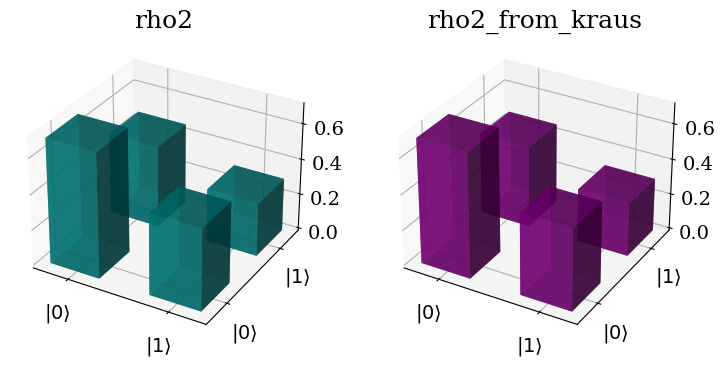

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


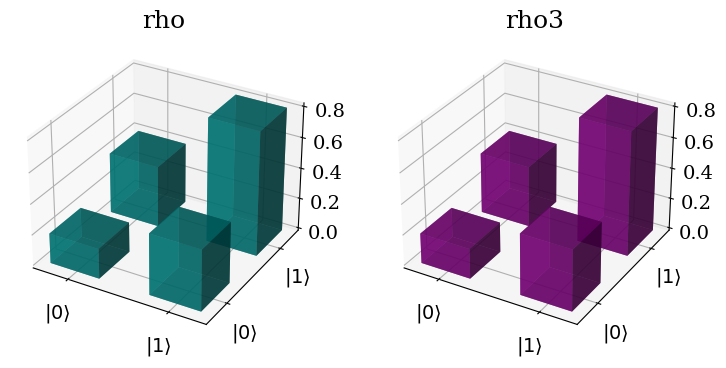

rho_rho3
tf.Tensor(1.4379596264824102e-06, shape=(), dtype=float64)
rho2_rho2
tf.Tensor(1.4438856246190568e-06, shape=(), dtype=float64)


In [104]:
folder_path = 'experiment_result_kraus/1_qubits'
rho2_file_path = os.path.join(folder_path, 'rho2.txt')
rho2 = parse_tensor_from_file(rho2_file_path, 2)
            
rho_file_path = os.path.join(folder_path, 'rho.txt')
rho= parse_tensor_from_file(rho_file_path, 2)

rho3_file_path = os.path.join(folder_path, 'rho3.txt')
rho3= parse_tensor_from_file(rho3_file_path, 2)

rho2o_file_path = os.path.join(folder_path, 'out_rho2.txt')
rho2o= parse_tensor_from_file(rho2o_file_path, 2)

plot_array(rho2.numpy(), rho2o.numpy(), 'rho2', 'rho2_from_kraus', "rho2_matrix")
plot_array(rho.numpy(), rho3.numpy(), 'rho', 'rho3', "rho3_matrix")

print("rho_rho3")
fildelity03 = abs(1 - metrics.compilation_trace_fidelity(rho, rho3))
print(fildelity03)
print("rho2_rho2")
fildelity22 = abs(1 - metrics.compilation_trace_fidelity(rho2, rho2o))
print(fildelity22)
         

[[0.70041158+0.j 0.45807772+0.j]
 [0.45807772+0.j 0.29958842+0.j]]
['0.70041158+0.j', '0.45807772+0.j', '0.45807772+0.j', '0.29958842+0.j']
[[0.19540954+0.j 0.39651564+0.j]
 [0.39651564+0.j 0.80459046+0.j]]
['0.19540954+0.j', '0.39651564+0.j', '0.39651564+0.j', '0.80459046+0.j']
[[0.19541042+0.j 0.3965145 +0.j]
 [0.3965145 +0.j 0.80458958+0.j]]
['0.19541042+0.j', '0.3965145 +0.j', '0.3965145 +0.j', '0.80458958+0.j']
[[0.700411 +0.j 0.4580764+0.j]
 [0.4580764+0.j 0.299589 +0.j]]
['0.700411 +0.j', '0.4580764+0.j', '0.4580764+0.j', '0.299589 +0.j']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


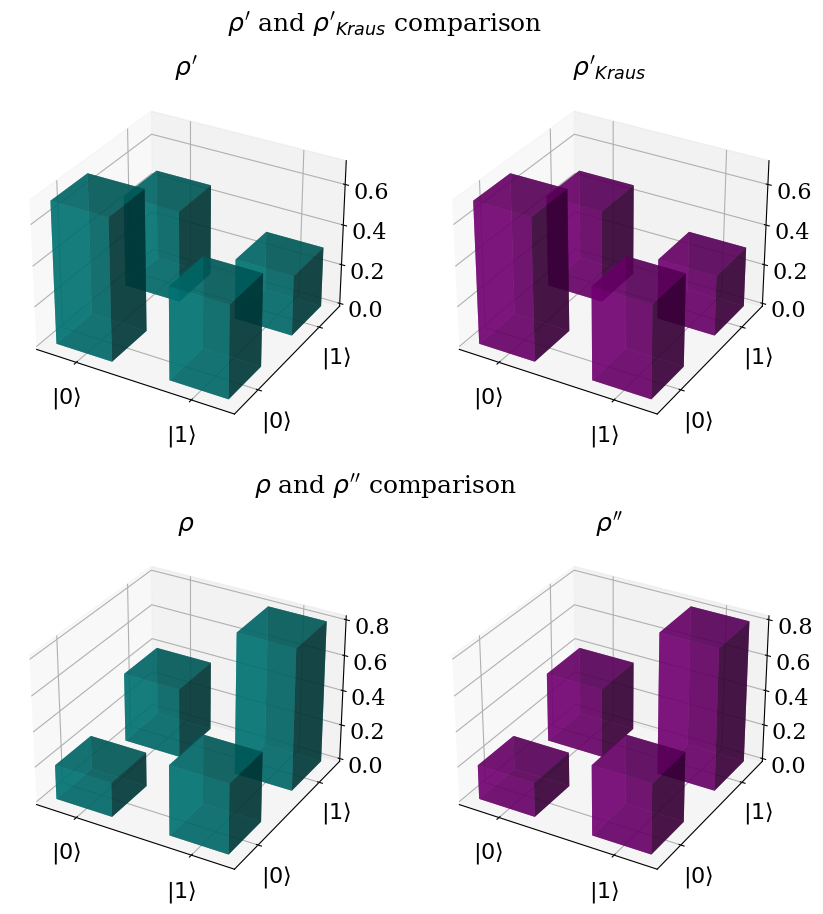

rho_rho3
tf.Tensor(1.4379596264824102e-06, shape=(), dtype=float64)
rho2_rho2
tf.Tensor(1.4438856246190568e-06, shape=(), dtype=float64)


In [105]:
import numpy as np
import matplotlib.pyplot as plt

def plot_array(array1, array2, array3, array4, title1, title2, title3, title4, label1, label2, file_name):
    # Create the figure and 3D axes
    fig = plt.figure(figsize=(10, 11))  # Tăng chiều cao để tạo không gian cho cả hai hàng
    
    # Grid positions for the bars
    x, y = np.meshgrid(np.arange(array1.shape[0]), np.arange(array1.shape[1]))
    
    # Flatten the grid and array values for easy plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)  # Base height of the bars (all start from z=0)
    
    # Colors for positive and negative values
    pos_color1 = 'teal'
    pos_color2 = 'purple'
    neg_color = 'red'
    
    # First plot with bars for Array 1
    ax1 = fig.add_subplot(221, projection='3d')
    colors1 = get_colors(array1, pos_color1, neg_color)
    ax1.bar3d(x, y, z, dx=0.5, dy=0.5, dz=array1.flatten(), color=colors1, alpha=0.7)
    ax1.set_title(title1, fontsize=18)

    # Second plot with bars for Array 2
    ax2 = fig.add_subplot(222, projection='3d')
    colors2 = get_colors(array2, pos_color2, neg_color)
    ax2.bar3d(x, y, z, dx=0.5, dy=0.5, dz=array2.flatten(), color=colors2, alpha=0.7)
    ax2.set_title(title2, fontsize=18)
    
    # Third plot with bars for Array 3
    ax3 = fig.add_subplot(223, projection='3d')
    colors3 = get_colors(array3, pos_color1, neg_color)
    ax3.bar3d(x, y, z, dx=0.5, dy=0.5, dz=array3.flatten(), color=colors3, alpha=0.7)
    ax3.set_title(title3, fontsize=18)

    # Fourth plot with bars for Array 4
    ax4 = fig.add_subplot(224, projection='3d')
    colors4 = get_colors(array4, pos_color2, neg_color)
    ax4.bar3d(x, y, z, dx=0.5, dy=0.5, dz=array4.flatten(), color=colors4, alpha=0.7)
    ax4.set_title(title4, fontsize=18)
    
    # Set x and y ticks for all subplots
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xticks([0.25, 1.25])  # Set the x-tick positions
        ax.set_xticklabels(['$| 0 \\rangle$', '$| 1 \\rangle$'])  # Set the x-tick labels
        ax.set_yticks([0.25, 1.25])  # Set the y-tick positions
        ax.set_yticklabels(['$| 0 \\rangle$', '$| 1 \\rangle$'])  # Set the y-tick labels
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.tick_params(axis='z', labelsize=16)

    # Adjust subplots to create space for row labels
    plt.subplots_adjust(top=0.9, hspace=0.1)  # Thêm khoảng cách giữa các hàng
    
    # Add labels for rows
    fig.text(0.5, 0.92, label1, ha='center', fontsize=18)  # Row 1
    fig.text(0.5, 0.50, label2, ha='center', fontsize=18)  # Row 2
    
    plt.savefig('docs/'+file_name+'.png', format='png',  bbox_inches='tight')
    plt.savefig('docs/'+file_name+'.eps', format='eps',  bbox_inches='tight')
    
    plt.show()

def get_colors(array, pos_color, neg_color):
    # Create an array of colors based on the values in the input array
    return [pos_color if value > 0 else neg_color for value in array.flatten()]


folder_path = 'experiment_result_kraus/1_qubits'
rho2_file_path = os.path.join(folder_path, 'rho2.txt')
rho2 = parse_tensor_from_file(rho2_file_path, 2)
            
rho_file_path = os.path.join(folder_path, 'rho.txt')
rho= parse_tensor_from_file(rho_file_path, 2)

rho3_file_path = os.path.join(folder_path, 'rho3.txt')
rho3= parse_tensor_from_file(rho3_file_path, 2)

rho2o_file_path = os.path.join(folder_path, 'out_rho2.txt')
rho2o= parse_tensor_from_file(rho2o_file_path, 2)

plot_array(rho2.numpy(), rho2o.numpy(), rho.numpy(), rho3.numpy(), "$ \\rho'$", "$ \\rho'_{Kraus}$", 
           "$ \\rho$", "$ \\rho''$", "$ \\rho'$ and $ \\rho'_{Kraus}$ comparison", 
           "$ \\rho$ and $ \\rho''$ comparison",
           "rho2_matrix")

print("rho_rho3")
fildelity03 = abs(1 - metrics.compilation_trace_fidelity(rho, rho3))
print(fildelity03)
print("rho2_rho2")
fildelity22 = abs(1 - metrics.compilation_trace_fidelity(rho2, rho2o))
print(fildelity22)
         

[[0.88413579+0.j 0.30363749+0.j]
 [0.30363749+0.j 0.11586421+0.j]]
['0.88413579+0.j', '0.30363749+0.j', '0.30363749+0.j', '0.11586421+0.j']
[[0.88413579+0.j 0.32006202+0.j]
 [0.32006202+0.j 0.11586421+0.j]]
['0.88413579+0.j', '0.32006202+0.j', '0.32006202+0.j', '0.11586421+0.j']
tf.Tensor(
[[0.88413579+0.j 0.32006202+0.j]
 [0.32006202+0.j 0.11586421+0.j]], shape=(2, 2), dtype=complex128)
[[-0.78148001+0.j -0.61629417+0.j]
 [-0.6157148 +0.j  0.7365238 +0.j]]
['-0.78148001+0.j', '-0.61629417+0.j', '-0.6157148 +0.j', '0.7365238 +0.j']
tf.Tensor(
[[-0.78148001+0.j -0.61629417+0.j]
 [-0.6157148 +0.j  0.7365238 +0.j]], shape=(2, 2), dtype=complex128)
[[0.88413579+0.j 0.07156804+0.j]
 [0.07156804+0.j 0.11586421+0.j]]
['0.88413579+0.j', '0.07156804+0.j', '0.07156804+0.j', '0.11586421+0.j']
[[0.88413579+0.j 0.32006202+0.j]
 [0.32006202+0.j 0.11586421+0.j]]
['0.88413579+0.j', '0.32006202+0.j', '0.32006202+0.j', '0.11586421+0.j']
tf.Tensor(
[[0.88413579+0.j 0.32006202+0.j]
 [0.32006202+0.j 0.1158

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


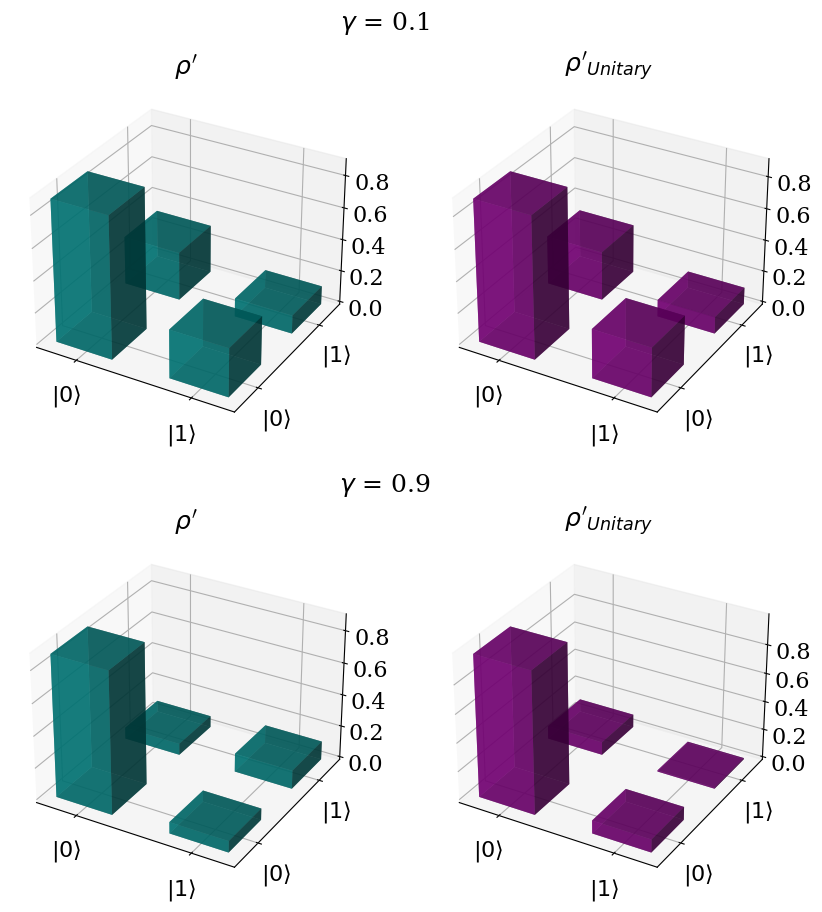

rho2_rho2
tf.Tensor(0.010351101828628417, shape=(), dtype=float64)


In [106]:
folder_path = 'experiment_result_dephasing_2/1_qubits_0.100'
rho2_file_path = os.path.join(folder_path, 'rho2.txt')
rho2 = parse_tensor_from_file(rho2_file_path, 2)
            
rho_file_path = os.path.join("experiment_result_dephasing_2", '1_qubits_rho.txt')
rho= parse_tensor_from_file(rho_file_path, 2)
print(rho)
unitary_file_path = os.path.join(folder_path, 'unitary.txt')
unitary= parse_tensor_from_file(unitary_file_path, 2)
print(unitary)
rho2o= epsilon_rho.calculate_from_unitary(rho=rho.numpy(), unitary_matrix=unitary.numpy())

folder_path = 'experiment_result_dephasing_2/1_qubits_0.950'
rho2_file_path = os.path.join(folder_path, 'rho2.txt')
rho2_2 = parse_tensor_from_file(rho2_file_path, 2)
            
rho_file_path = os.path.join("experiment_result_dephasing_2", '1_qubits_rho.txt')
rho= parse_tensor_from_file(rho_file_path, 2)
print(rho)
unitary_file_path = os.path.join(folder_path, 'unitary.txt')
unitary= parse_tensor_from_file(unitary_file_path, 2)

rho2o_2= epsilon_rho.calculate_from_unitary(rho=rho.numpy(), unitary_matrix=unitary.numpy())

plot_array(rho2.numpy(), rho2o, rho2_2.numpy(), rho2o_2, "$ \\rho'$", "$ \\rho'_{Unitary}$", 
           "$ \\rho'$", "$ \\rho'_{Unitary}$", "$ \\gamma$ = 0.1", 
           "$ \\gamma$ = 0.9",
           "rho2_matrix_dephasing_2")
print("rho2_rho2")
fildelity22 = abs(1 - metrics.compilation_trace_fidelity(rho2, rho2o))
print(fildelity22)
         